**資科工碩 0756110 李東霖**

# Introduction

In [1]:
import dataloader
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
from IPython.display import clear_output

In [3]:
def show_data(data):
    if len(data.shape) == 3:
        data = data[0]
        
    if len(data.shape) != 2:
        raise AttributeError("shape no ok")
        return
    
    plt.figure(figsize=(10,4))
    for i in range(data.shape[0]):
        plt.subplot(2,1, i+1)
        plt.ylabel("Channel "+str(i+1), fontsize=15)
        plt.plot(np.array(data[i, :]))
    plt.show()
    
def gen_dataset(train_x, train_y, test_x, test_y):
    datasets = []
    for x, y in [(train_x, train_y), (test_x, test_y)]:
        x = torch.stack(
            [torch.Tensor(x[i]) for i in range(x.shape[0])]
        )
        y = torch.stack(
            [torch.Tensor(y[i:i+1]) for i in range(y.shape[0])]
        )
        datasets += [TensorDataset(x, y)]
        
    return datasets

In [4]:
train_dataset, test_dataset = gen_dataset(*dataloader.read_bci_data())

(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)


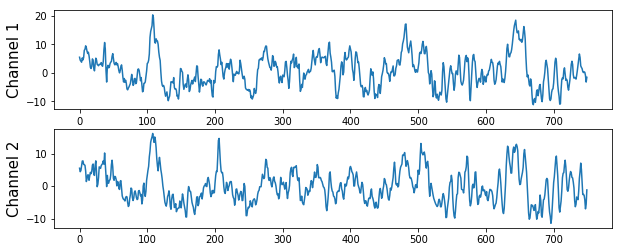

In [5]:
show_data(train_dataset[0][0])

# Activation function

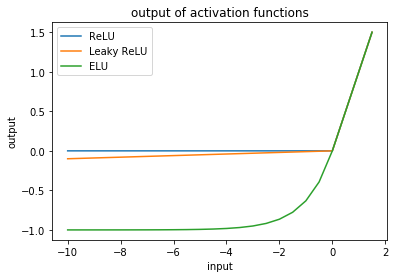

In [47]:
x = torch.arange(-10, 2, 0.5, dtype=torch.float, requires_grad=True)

y = nn.ReLU()(x)
plt.plot(x.data.numpy(), y.data.numpy(), label="ReLU")

y = nn.LeakyReLU()(x)
plt.plot(x.data.numpy(), y.data.numpy(), label="Leaky ReLU")

y = nn.ELU()(x)
plt.plot(x.data.numpy(), y.data.numpy(), label="ELU")

plt.legend()
plt.title('output of activation functions')
plt.ylabel('output')
plt.xlabel('input')
plt.show()

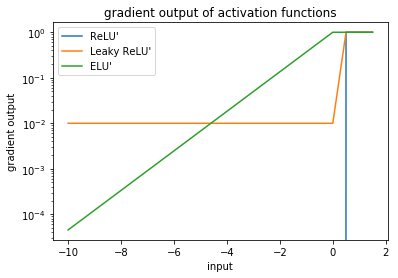

In [55]:
x = torch.arange(-10, 2, 0.5, dtype=torch.float, requires_grad=True)

y = nn.ReLU()(x)
y.backward(torch.ones_like(y))
plt.plot(x.data.numpy(), x.grad.data.numpy(), label="ReLU'")

y = nn.LeakyReLU()(x)
x.grad.data.zero_()
y.backward(torch.ones_like(y))
plt.plot(x.data.numpy(), x.grad.data.numpy(), label="Leaky ReLU'")

y = nn.ELU()(x)
x.grad.data.zero_()
y.backward(torch.ones_like(y))
plt.plot(x.data.numpy(), x.grad.data.numpy(), label="ELU'")

plt.legend()
plt.title('gradient output of activation functions')
plt.ylabel('gradient output')
plt.xlabel('input')
plt.yscale('log')
plt.show()

# EEGNet

In [6]:
class EEGNet(nn.Module):
    def __init__(self, activation=None, dropout=0.25):
        super(EEGNet, self).__init__()
        
        if not activation:
            activation = nn.ELU
        
        self.firstconv = nn.Sequential(
            nn.Conv2d(
                1, 16, kernel_size=(1, 51),
                stride=(1,1), padding=(0,25), bias=False
            ),
            nn.BatchNorm2d(16)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(
                16, 32, kernel_size=(2,1),
                stride=(1,1), groups=16, bias=False
            ),
            nn.BatchNorm2d(32),
            activation(),
            nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0),
            nn.Dropout(p=dropout)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(
                32, 32, kernel_size=(1, 15), 
                stride=(1,1), padding=(0, 7), bias=False
            ),
            nn.BatchNorm2d(32),
            activation(),
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0),
            nn.Dropout(p=dropout)
        )
        self.classify = nn.Sequential(
            nn.Linear(736, 2, bias=True)
        )
        
    def forward(self, x):
        x = self.firstconv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        # flatten
        x = x.view(-1, self.classify[0].in_features)
        x = self.classify(x)
        return x

# DeepConvNet

In [7]:
from functools import reduce
class DeepConvNet(nn.Module):
    def __init__(self, activation=None, deepconv=[25,50,100,200]):
        super(DeepConvNet, self).__init__()
        
        if not activation:
            activation = nn.ELU
        
        self.deepconv = deepconv
        self.conv0 = nn.Sequential(
            nn.Conv2d(
                1, deepconv[0], kernel_size=(1, 5),
                stride=(1,1), padding=(0,0), bias=True
            ),
            nn.Conv2d(
                deepconv[0], deepconv[0], kernel_size=(2,1),
                stride=(1,1), padding=(0,0), bias=True
            ),
            nn.BatchNorm2d(deepconv[0]),
            activation(),
            nn.MaxPool2d(kernel_size=(1,2)),
            nn.Dropout(p=0.5)
        )
        
        for idx in range(1, len(deepconv)):
            setattr(self, 'conv'+str(idx), nn.Sequential(
                nn.Conv2d(
                    deepconv[idx-1], deepconv[idx], kernel_size=(1,5),
                    stride=(1,1), padding=(0,0), bias=True
                ),
                nn.BatchNorm2d(deepconv[idx]),
                activation(),
                nn.MaxPool2d(kernel_size=(1, 2)),
                nn.Dropout(p=0.5)
            ))
        
        
        flatten_size =  deepconv[-1] * reduce(
            lambda x,_: round((x-4)/2), deepconv, 750)
        self.classify = nn.Sequential(
            nn.Linear(flatten_size, 2, bias=True),
        )
    
    def forward(self, x):
        for i in range(len(self.deepconv)):
            x = getattr(self, 'conv'+str(i))(x)
        # flatten
        x = x.view(-1, self.classify[0].in_features)
        x = self.classify(x)
        return x

In [31]:
def showAccuracy(title='', accline=[80, 85], **kwargs):
    fig = plt.figure(figsize=(8,4.5))
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy(%)')
    
    for label, data in kwargs.items():
        plt.plot(
            range(1, len(data)+1), data, 
            '--' if 'test' in label else '-', 
            label=label
        )
    
    plt.legend(
        loc='best', bbox_to_anchor=(1.0, 1.0, 0.2, 0),
        fancybox=True, shadow=True
    )
    
    if accline:
        plt.hlines(accline, 1, len(data)+1, linestyles='dashed', colors=(0,0,0,0.8))
    
    plt.show()
    
    return fig

class AccuracyResult():
    def __init__(self, fileName = "AccuracyResult.csv"):
        self.filepath = os.path.join('.', fileName)
        if os.path.isfile(self.filepath):
            self.df = pd.read_csv(self.filepath, index_col=0)
        else:
            self.df = pd.DataFrame(columns = ["ReLU", "Leaky ReLU", "ELU"])
        self.mapping = {
            'ELU' : 'elu',
            'ReLU' : 'relu',
            'Leaky ReLU' : 'leaky_relu',
        }
        
    def add(self, modelName, Accs, show=False):
        rows = [0.0]*len(self.df.columns)
        if modelName in self.df.index:
            rows = self.df.loc[modelName]
        for idx, col in enumerate(self.df.columns):
            if Accs[self.mapping[col] + '_test']:
                acc = max(Accs[self.mapping[col] + '_test'])
                if acc > rows[idx]:
                    rows[idx] = acc 
                
        if len(rows) != len(self.df.columns):
            raise AttributeError("Not enougth columns")
        
        self.df.loc[modelName] = rows
        
        self.df.to_csv(self.filepath)
        
        if show:
            fig = showAccuracy(
                title=modelName,
                **Accs
            )
            fig.savefig(
                fname=os.path.join('.', modelName + '.png'),
                dpi=300,
                metadata = {
                    'Title': modelName,
                    'Author': '0756110',
                },
                bbox_inches="tight",
            )
        
    def show(self):
        print(self.df)
    
    def clear(self):
        self.df = self.df.iloc[0:0]
        if os.path.isfile(self.filepath):
            os.remove(self.filepath)

AccRes = AccuracyResult()
AccRes.show()

             ReLU  Leaky ReLU        ELU
EEGNet  78.796296   80.555556  81.018519


In [13]:
def runModels(
    models, epoch_size, batch_size, learning_rate, 
    optimizer = optim.Adam, criterion = nn.CrossEntropyLoss(),
    show = True
):
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, len(test_dataset))
    
    Accs = {
    **{key+"_train" : [] for key in models},
    **{key+"_test" : [] for key in models}
    }
    
    optimizers = {
        key: optimizer(value.parameters(), lr=learning_rate) 
        for key, value in models.items()
    }
    for epoch in range(epoch_size):
        train_correct = {key:0.0 for key in models}
        test_correct = {key:0.0 for key in models}
        # training multiple model
        for idx, data in enumerate(train_loader):
            x, y = data
            inputs = x.to(device)
            labels = y.to(device).long().view(-1)
        
            for optimizer in optimizers.values():
                optimizer.zero_grad()
        
            for key, model in models.items():
                outputs = model.forward(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
            
                train_correct[key] += (
                    torch.max(outputs, 1)[1] == labels
                ).sum().item()
        
            for optimizer in optimizers.values():
                optimizer.step()
        
        # testing multiple model
        with torch.no_grad():
            for _, data in enumerate(test_loader):
                x, y = data
                inputs = x.to(device)
                labels = y.to(device)
        
                for key, model in models.items():
                    outputs = model.forward(inputs)
        
                    test_correct[key] += (
                        torch.max(outputs, 1)[1] == labels.long().view(-1)
                    ).sum().item()

        for key, value in train_correct.items():
            Accs[key+"_train"] += [(value*100.0) / len(train_dataset)]
    
        for key, value in test_correct.items():
            Accs[key+"_test"] += [(value*100.0) / len(test_dataset)]
         
        if show:
            clear_output(wait=True)
            showAccuracy(
                title='Epoch [{:4d}]'.format(epoch + 1),
                **Accs
            )
        
    # epoch end
    torch.cuda.empty_cache()
    return Accs

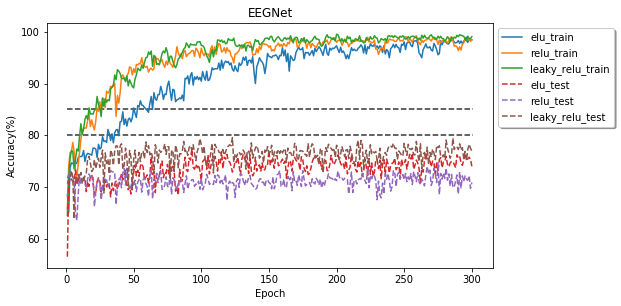

CPU times: user 1min 56s, sys: 7.17 s, total: 2min 3s
Wall time: 2min 47s


In [33]:
%%time
# Training & Testing EEGNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = {
    "elu" : EEGNet(nn.ELU).to(device),
    "relu" : EEGNet(nn.ReLU).to(device),
    "leaky_relu" : EEGNet(nn.LeakyReLU).to(device),
}
Accs = runModels(models, epoch_size=300, batch_size=64, learning_rate=1e-2, show=False)
AccRes.add("EEGNet", Accs, show=True)

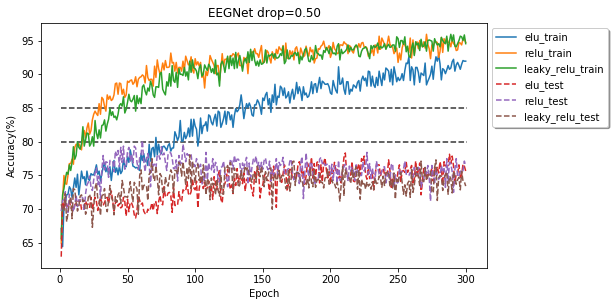

CPU times: user 1min 55s, sys: 6.98 s, total: 2min 2s
Wall time: 2min 45s


In [34]:
%%time
# Training & Testing EEGNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dropout_p = 0.5
models = {
    "elu" : EEGNet(nn.ELU, dropout=dropout_p).to(device),
    "relu" : EEGNet(nn.ReLU, dropout=dropout_p).to(device),
    "leaky_relu" : EEGNet(nn.LeakyReLU, dropout=dropout_p).to(device),
}
Accs = runModels(models, epoch_size=300, batch_size=64, learning_rate=1e-2, show=False)
AccRes.add("EEGNet drop={:1.2f}".format(dropout_p), Accs, show=True)

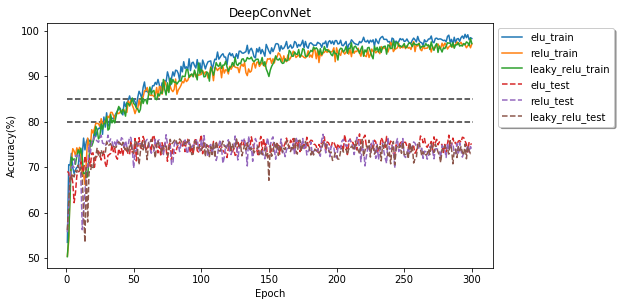

CPU times: user 3min, sys: 17.3 s, total: 3min 17s
Wall time: 3min 18s


In [35]:
%%time
# Training & Testing DeepConvNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = {
    "elu" : DeepConvNet(nn.ELU).to(device),
    "relu" : DeepConvNet(nn.ReLU).to(device),
    "leaky_relu" : DeepConvNet(nn.LeakyReLU).to(device),
}
Accs = runModels(models, epoch_size=300, batch_size=64, learning_rate=1e-3, show=False)
AccRes.add("DeepConvNet", Accs, show=True)

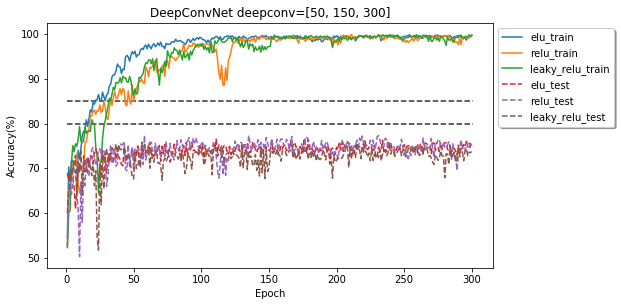

CPU times: user 4min 19s, sys: 39.3 s, total: 4min 58s
Wall time: 4min 59s


In [36]:
%%time
# Training & Testing EEGNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deepconv = [50, 150, 300]
models = {
    "elu" : DeepConvNet(nn.ELU, deepconv=deepconv).to(device),
    "relu" : DeepConvNet(nn.ReLU, deepconv=deepconv).to(device),
    "leaky_relu" : DeepConvNet(nn.LeakyReLU, deepconv=deepconv).to(device),
}
Accs = runModels(models, epoch_size=300, batch_size=64, learning_rate=1e-3, show=False)
AccRes.add("DeepConvNet deepconv="+str(deepconv), Accs, show=True)